# Customer Churn Prediction
Predict which customers are likely to leave a service.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [3]:
# Load dataset
# df = pd.read_csv('customer_data.csv')

In [4]:
# Data preprocessing

In [5]:
# Model training and evaluation

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Confusion Matrix (Test Set):
 [[822 211]
 [125 249]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1033
           1       0.54      0.67      0.60       374

    accuracy                           0.76      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.76      0.77      1407


AUC (Test Set): 0.8165019594038443


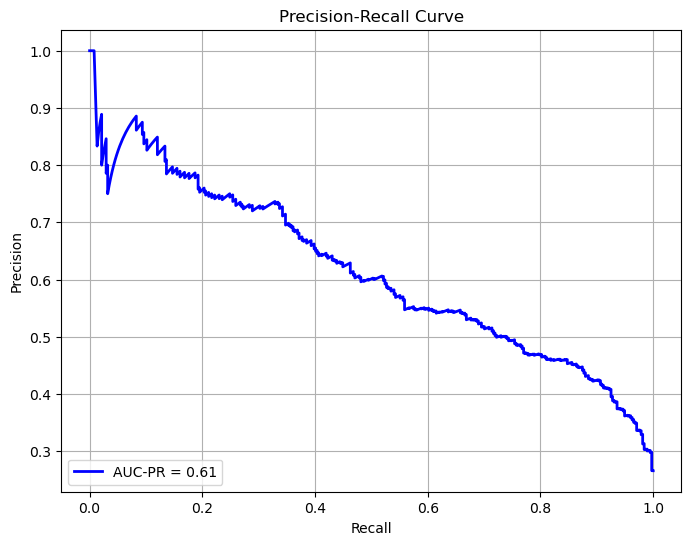


Feature Importance:
              Feature  Importance
14          Contract    0.201903
8     OnlineSecurity    0.132514
11       TechSupport    0.112343
4             tenure    0.104191
17    MonthlyCharges    0.091025
18      TotalCharges    0.088581
9       OnlineBackup    0.041410
3         Dependents    0.037525
7    InternetService    0.034960
2            Partner    0.031909
16     PaymentMethod    0.029152
10  DeviceProtection    0.024960
0             gender    0.015693
12       StreamingTV    0.011401
6      MultipleLines    0.011020
13   StreamingMovies    0.010629
15  PaperlessBilling    0.008120
1      SeniorCitizen    0.006669
5       PhoneService    0.005995

Model saved as churn_prediction_model.pkl


In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Convert 'TotalCharges' to numeric (fixing bad entries)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Encode categorical variables
le = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    if column != 'customerID':
        df[column] = le.fit_transform(df[column])

# Define features and target
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# Split data before SMOTE to avoid data leakage in validation
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance classes using SMOTE on the training/validation set
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_val, y_train_val)

# Scale numerical features
scaler = StandardScaler()
numerical_features = X_res.select_dtypes(include=['int64', 'float64']).columns
X_res[numerical_features] = scaler.fit_transform(X_res[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Train-test split for hyperparameter tuning (optional, can use cross-validation directly)
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.25, random_state=42)

# Hyperparameter tuning (example)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Train final model on the entire resampled training/validation set
final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_model.fit(X_res, y_res)

# Predictions and Evaluation on the test set
y_pred = final_model.predict(X_test)
print("\nConfusion Matrix (Test Set):\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred))
print("\nAUC (Test Set):", roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1]))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, final_model.predict_proba(X_test)[:, 1])
auc_pr = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Feature Importance
feature_importances = final_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", importance_df)

# Save the trained model
joblib.dump(final_model, 'churn_prediction_model.pkl')
print("\nModel saved as churn_prediction_model.pkl")